In [ ]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import numpy as np
import os
import gc

device = "cuda" if torch.cuda.is_available() else "cpu"

def crop_and_save_largest_mask(image_path, output_path=None, text_prompt="wing", threshold=0.5):
    """
    Crop an image based on the largest detected mask and save it.
    
    Args:
        image_path: Path to input image
        output_path: Path to save cropped image (default: adds '_cropped' to filename)
        text_prompt: Text prompt for segmentation (default: "wing")
        threshold: Threshold for mask detection (default: 0.5)
    
    Returns:
        Path to saved cropped image, or None if no masks found
    """
    # Load SAM3 model
    print("Loading SAM3 model...")
    model = Sam3Model.from_pretrained("facebook/sam3").to(device)
    processor = Sam3Processor.from_pretrained("facebook/sam3")
    
    try:
        # Load image
        image = Image.open(image_path)
        
        # Segment using text prompt
        inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Post-process results
        results = processor.post_process_instance_segmentation(
            outputs,
            threshold=threshold,
            mask_threshold=threshold,
            target_sizes=inputs.get("original_sizes").tolist()
        )[0]
        
        print(f"Found {len(results['masks'])} objects in {os.path.basename(image_path)}")
        
        # Crop based on largest mask if any masks found
        if len(results['masks']) > 0:
            # Find the largest mask by area
            largest_idx = 0
            largest_area = 0
            
            for idx, mask in enumerate(results['masks']):
                area = mask.sum().item()
                if area > largest_area:
                    largest_area = area
                    largest_idx = idx
            
            print(f"Largest mask is #{largest_idx} with area {largest_area}")
            
            # Get bounding box of the largest mask
            largest_mask = results['masks'][largest_idx].cpu().numpy()
            y_coords, x_coords = np.where(largest_mask)
            
            if len(y_coords) > 0:
                y_min, y_max = y_coords.min(), y_coords.max()
                x_min, x_max = x_coords.min(), x_coords.max()
                
                # Crop the image
                cropped_image = image.crop((x_min, y_min, x_max, y_max))
                
                # Determine output path
                if output_path is None:
                    base, ext = os.path.splitext(image_path)
                    output_path = f"{base}_cropped{ext}"
                
                # Save the cropped image
                cropped_image.save(output_path)
                print(f"Cropped image saved to {output_path} (bbox: {x_min},{y_min} to {x_max},{y_max})")
                
                return output_path
        
        print("No masks found, skipping crop")
        return None
    
    finally:
        # Unload SAM3 model to free memory
        print("Unloading SAM3 model...")
        del model
        del processor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

# Example usage:
# crop_and_save_largest_mask("/home/connor/projects/big-bee/data/uncropped/UCSB-IZC00055302_L.JPG")

SyntaxError: expected 'except' or 'finally' block (2022244334.py, line 35)

In [ ]:
import numpy as np
from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt
import torch
import gc

# A common issue is having an old version of transformers.
# Installing directly from the main branch on GitHub usually fixes things.
# pip install git+https://github.com/huggingface/transformers.git

device = "cuda" if torch.cuda.is_available() else "cpu"

def crop_wing_and_segment(image_path, output_cropped_path=None, visualize=True):
    """
    Crop wing from image using SAM3, then segment it using SAM.
    
    Args:
        image_path: Path to input image
        output_cropped_path: Optional path to save cropped image
        visualize: Whether to display the results (default: True)
    
    Returns:
        dict with keys:
            - 'cropped_image': PIL Image of cropped wing
            - 'masks': list of segmentation masks from SAM
            - 'cropped_path': path where cropped image was saved (if saved)
    """
    # Step 1: Crop wing using SAM3
    print("Step 1: Cropping wing using SAM3...")
    cropped_path = crop_and_save_largest_mask(
        image_path, 
        output_path=output_cropped_path,
        text_prompt="wing"
    )
    
    if cropped_path is None:
        print("Failed to crop wing - no masks detected")
        return None
    
    # Step 2: Load SAM model and segment cropped wing
    print("\nStep 2: Loading SAM model...")
    generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=device)
    
    try:
        print("Segmenting cropped wing with SAM...")
        cropped_image = Image.open(cropped_path)
        results = generator(cropped_image)
        masks = results["masks"]
        
        print(f"Found {len(masks)} masks in the cropped wing.")
        
        # Step 3: Visualize results
        if visualize:
            def show_masks_on_image(img, mask_list):
                if not mask_list:
                    print("No masks to show.")
                    return
                plt.figure(figsize=(10, 10))
                plt.imshow(img)
                ax = plt.gca()
                ax.set_autoscale_on(False)

                for idx, mask in enumerate(mask_list):
                    # Give each mask a random color
                    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
                    h, w = mask.shape[-2:]
                    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
                    ax.imshow(mask_image)
                    
                    # Add mask number at the centroid
                    y_coords, x_coords = np.where(mask.reshape(h, w))
                    if len(y_coords) > 0:
                        center_y = int(np.mean(y_coords))
                        center_x = int(np.mean(x_coords))
                        ax.text(center_x, center_y, str(idx), fontsize=12, 
                               color='white', weight='bold', ha='center', va='center',
                               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

                plt.axis('off')
                plt.title("SAM Segmentation on Cropped Wing")
                plt.show()
            
            show_masks_on_image(cropped_image, masks)
        
        return {
            'cropped_image': cropped_image,
            'masks': masks,
            'cropped_path': cropped_path
        }
    
    finally:
        # Unload SAM model to free memory
        print("\nUnloading SAM model...")
        del generator
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

# Example usage:
# result = crop_wing_and_segment("/home/connor/projects/big-bee/data/uncropped/UCSB-IZC00055302_L.JPG")

Loading weights: 100%|██████████| 594/594 [00:00<00:00, 1120.71it/s, Materializing param=vision_encoder.pos_embed]                                                 


Step 1: Cropping wing using SAM3...
Found 1 objects in UCSB-IZC00055302_L.JPG
Largest mask is #0 with area 183227
Cropped image saved to /home/connor/projects/big-bee/data/uncropped/UCSB-IZC00055302_L_cropped.JPG (bbox: 2996,1806 to 3868,2124)

Step 2: Segmenting cropped wing with SAM...
Found 31 masks in the cropped wing.


/tmp/ipykernel_3974420/3240398493.py:65: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


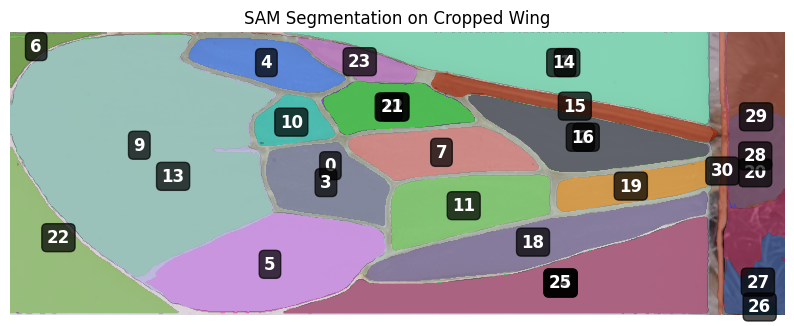

In [22]:
result = crop_wing_and_segment("/home/connor/projects/big-bee/data/uncropped/UCSB-IZC00055302_L.JPG")